## Loading the dataset and basic exploration

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.api import qqplot

In [3]:
df= pd.read_csv("sunspots.csv")
df.head(10)

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
5,1705,58.0
6,1706,29.0
7,1707,20.0
8,1708,10.0
9,1709,8.0


In [4]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [5]:
df.shape

(309, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    int64  
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.0 KB


## Preparation of data

In [7]:
#we will convert the year column into a date-time object
df.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del df["YEAR"]
df.head()

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


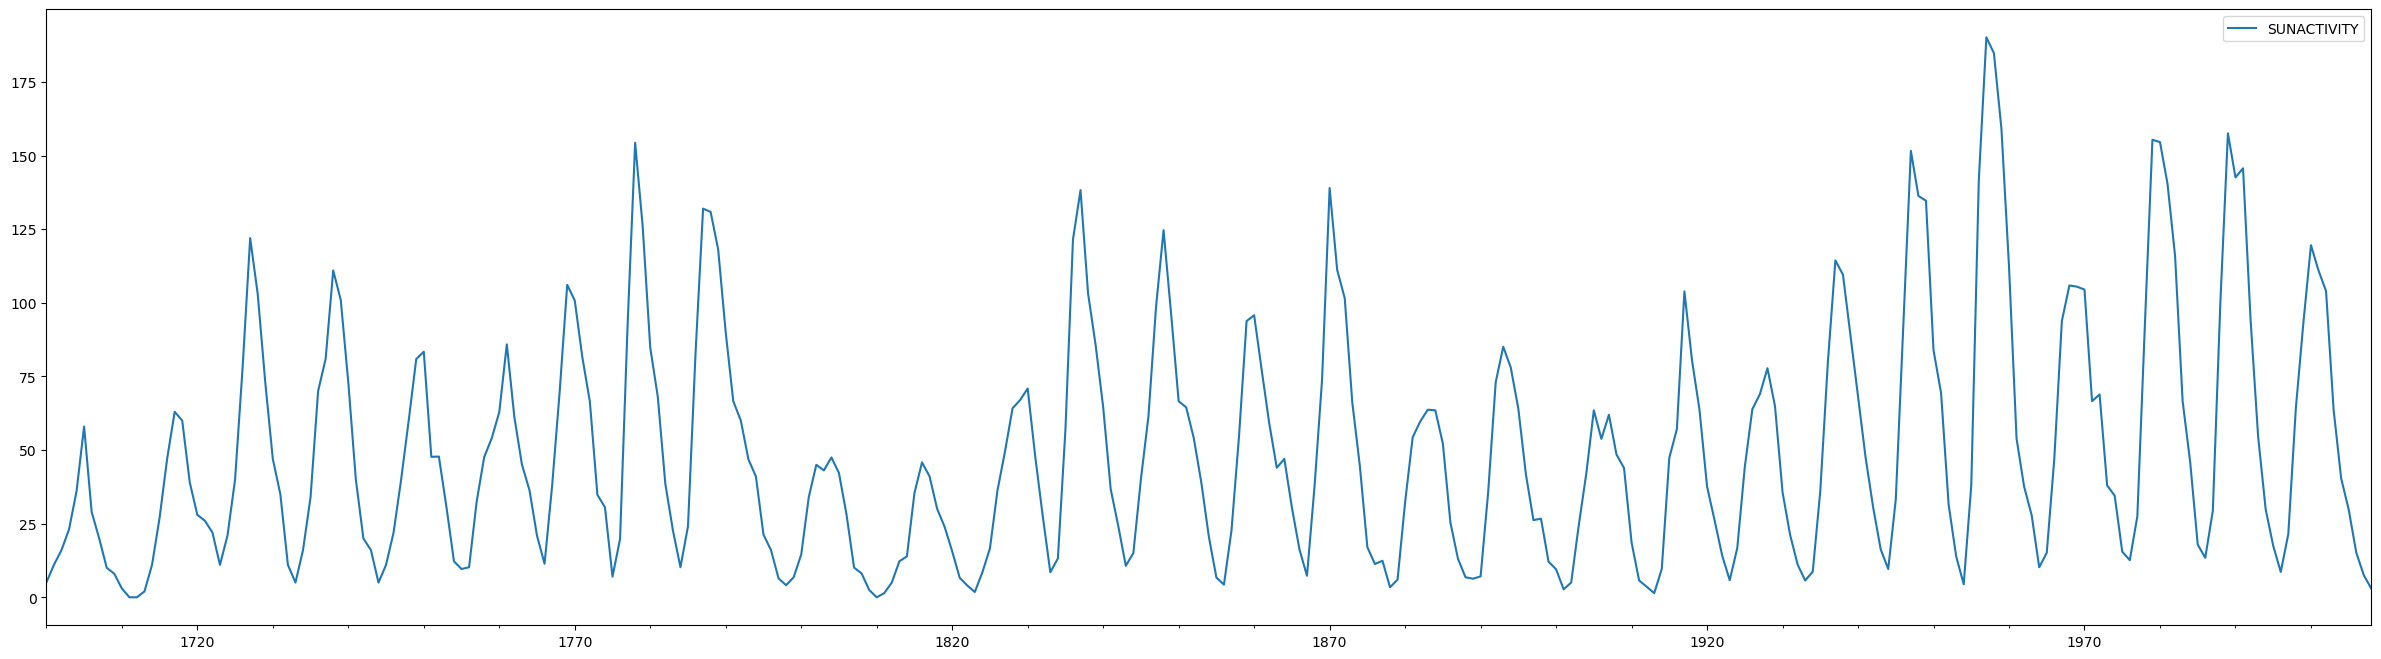

In [8]:
#plotting the data o have a basic look at the distribution
# show plots in the notebook
%matplotlib inline
df.plot(figsize=(30,8));

In [9]:
# Durbin-Watson statistic value lies in the 0-4 range, with a value near two indicating no first-order serial correlation. 
#Positive serial correlation is associated with DW values below 2 and negative serial correlation with DW values above 2.
sm.stats.durbin_watson(df)


array([0.13952893])

The value of **Durbin-Watson** statistic in our example is 0.1395. That means that there is a strong evidence that the variable open has high autocorrelation.

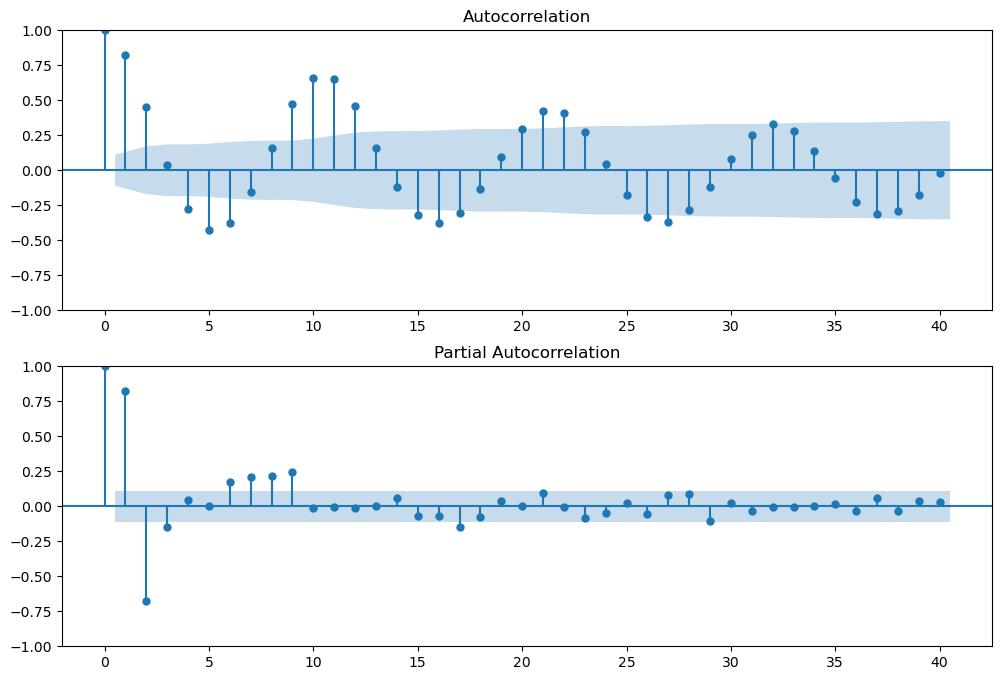

In [10]:
# plotting the ACF and PACF
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

 The plots indicate that *autocorrelation* is present

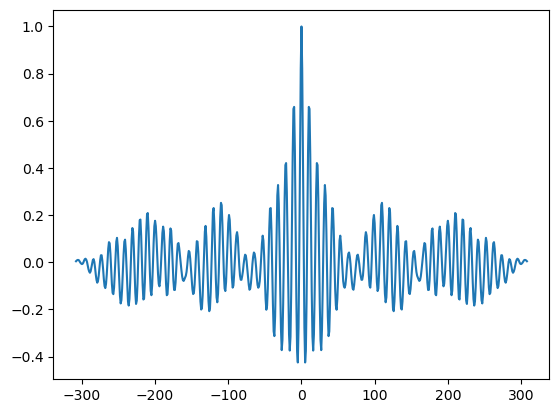

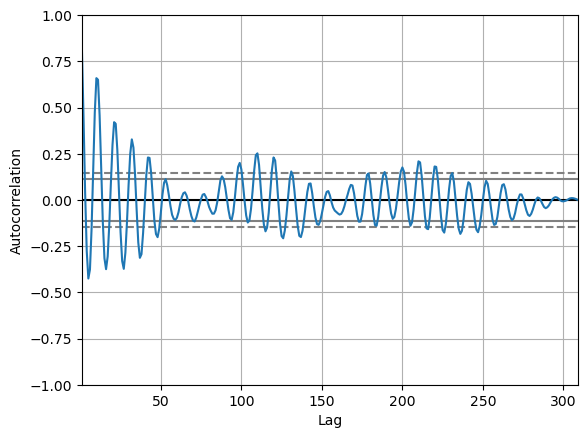

In [11]:
#using pandas for ACF plots
from pandas.plotting import autocorrelation_plot
# show plots in the notebook
%matplotlib inline
df['SUNACTIVITY_2'] = df['SUNACTIVITY']
df['SUNACTIVITY_2'] = (df['SUNACTIVITY_2'] - df['SUNACTIVITY_2'].mean()) / (df['SUNACTIVITY_2'].std())
plt.acorr(df['SUNACTIVITY_2'],maxlags = len(df['SUNACTIVITY_2']) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(df['SUNACTIVITY'])
plt.show()

# Modeling the Data

from statsmodels.tsa.arima.model import ARIMA

arma_mod20 = ARIMA(df['SUNACTIVITY'], order=(1, 0, 0)).fit()
print(arma_mod20.params)


In [12]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod20 = ARIMA(df['SUNACTIVITY'], order=(1, 0, 0)).fit()
print(arma_mod20.params)


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


const      48.396327
ar.L1       0.824423
sigma2    524.556483
dtype: float64


In [13]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2819.1691528948577 2830.369176725551 2823.6469437787923


In [14]:
sm.stats.durbin_watson(arma_mod20.resid.values)

0.8636725847947069

The Durbin-Watson test shows no autocorrelation.

## Plotting the Data

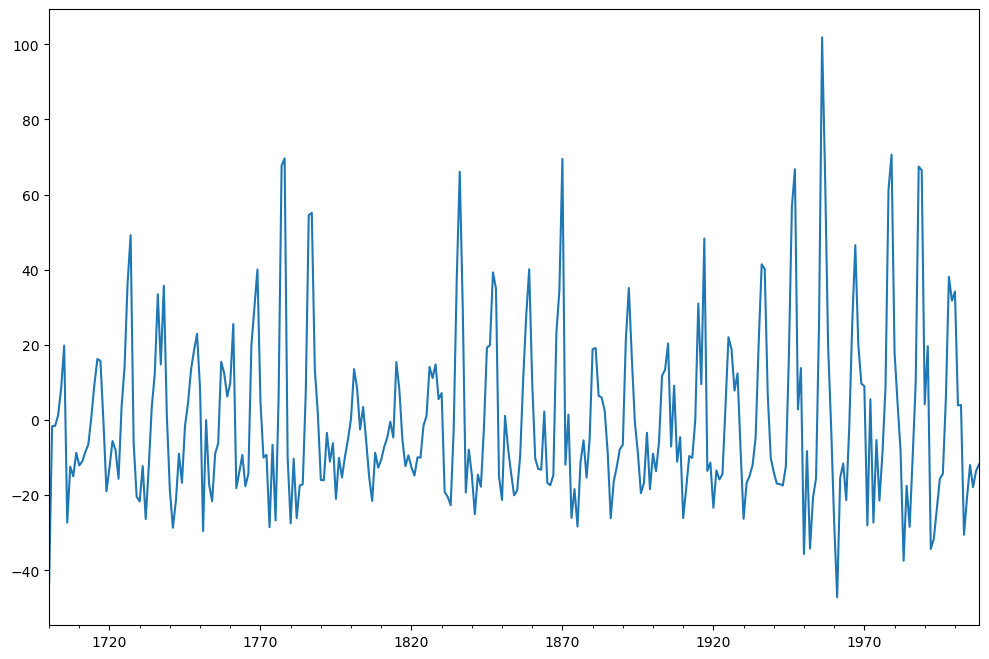

In [15]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);

## Analyzing the Residuals

In the following steps, we calculate the residuals, tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot.

In [16]:
resid20 = arma_mod20.resid
stats.normaltest(resid20)


NormaltestResult(statistic=72.08090470116925, pvalue=2.2275651708256876e-16)

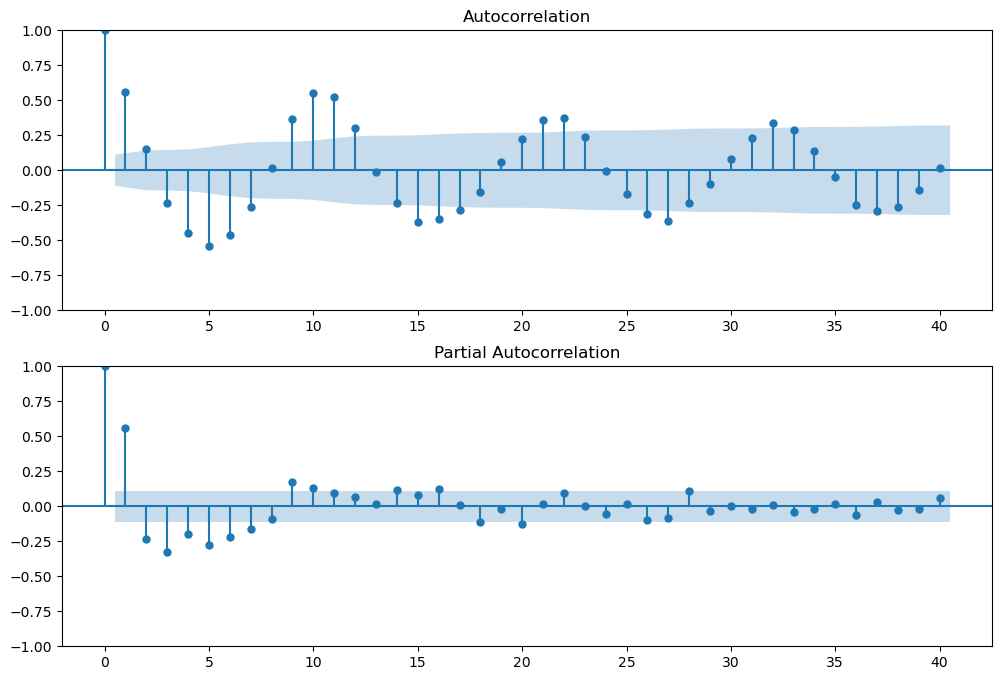

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20, lags=40, ax=ax2)

Next, we calculate the lag, autocorrelation (AC), Q statistic and Prob>Q. The Ljung–Box Q test (named for Greta M. Ljung and George E. P. Box) is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. The null hypothesis is, H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).

In [18]:
r, q, p = sm.tsa.acf(resid20.values.squeeze(), nlags=24, qstat=True)
data = np.c_[range(1, 25), r[1:25], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))


            AC           Q       Prob(>Q)
lag                                      
1.0   0.561924   98.519879   3.217783e-23
2.0   0.154948  106.035257   9.434881e-24
3.0  -0.236913  123.662064   1.255025e-26
4.0  -0.445261  186.128635   3.598366e-39
5.0  -0.539181  278.028297   5.279008e-58
6.0  -0.462536  345.881035   1.182152e-71
7.0  -0.260944  367.548408   2.152427e-75
8.0   0.015899  367.629111   1.557573e-74
9.0   0.365134  410.336476   8.525960e-83
10.0  0.550093  507.593102  1.052354e-102
11.0  0.523268  595.890978  1.059898e-120
12.0  0.299587  624.931769  5.007319e-126
13.0 -0.009196  624.959227  3.645987e-125
14.0 -0.235965  643.097263  3.527813e-128
15.0 -0.369180  687.647190  7.973030e-137
16.0 -0.351380  728.142610  1.318632e-144
17.0 -0.281669  754.252968  2.518883e-149
18.0 -0.157575  762.452719  3.080522e-150
19.0  0.059680  763.632999  1.143153e-149
20.0  0.223295  780.212846  2.238350e-152
21.0  0.359879  823.428387  9.755165e-161
22.0  0.374551  870.402527  6.7873

Notice that the p-values for the Ljung–Box Q test all are well above .05 for lags 1 through 8, indicating “significance.” This is not a desirable result. However, the p-values for the remaining lags through 40 data values as less than .05. So there is much data not contributing to correlations at high lags.


## Predictions

Next, we compute the predictions and analyze their fit against actual values.

In [19]:
predict_sunspots20 = arma_mod20.predict('1990', '2012', dynamic=True)
print(predict_sunspots20)

1990-12-31    138.426401
1991-12-31    122.619235
1992-12-31    109.587436
1993-12-31     98.843715
1994-12-31     89.986339
1995-12-31     82.684110
1996-12-31     76.663981
1997-12-31     71.700845
1998-12-31     67.609120
1999-12-31     64.235805
2000-12-31     61.454765
2001-12-31     59.162010
2002-12-31     57.271809
2003-12-31     55.713483
2004-12-31     54.428762
2005-12-31     53.369608
2006-12-31     52.496417
2007-12-31     51.776538
2008-12-31     51.183052
2009-12-31     50.693769
2010-12-31     50.290392
2011-12-31     49.957839
2012-12-31     49.683674
Freq: A-DEC, Name: predicted_mean, dtype: float64


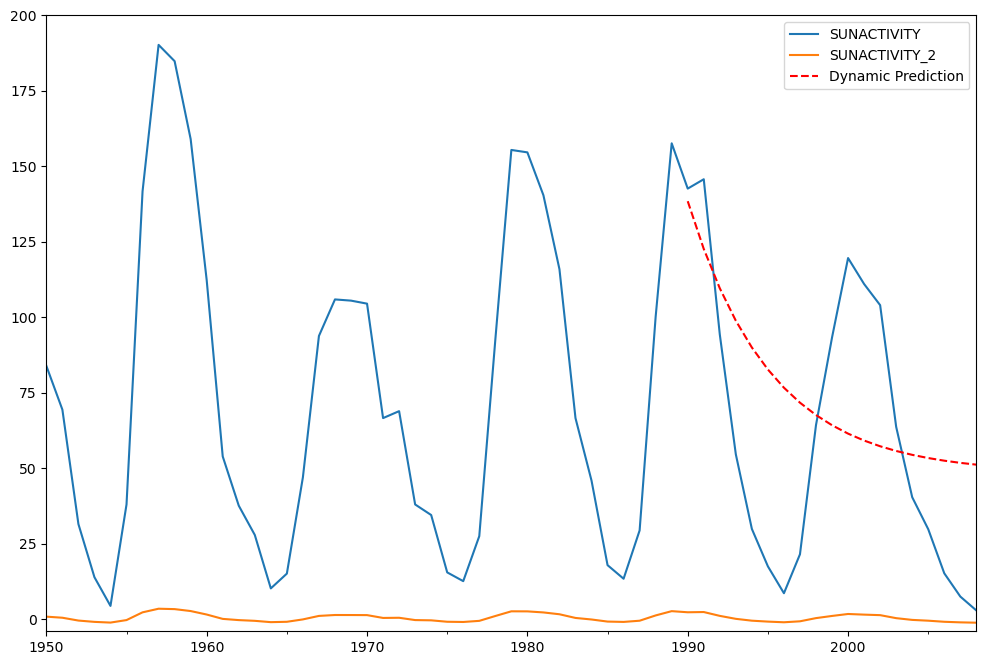

In [21]:
ax = df.loc['1950':].plot(figsize=(12,8))
ax = predict_sunspots20.plot(ax=ax, style='r--', label='Dynamic Prediction');
ax.legend();
ax.axis((-20.0, 38.0, -4.0, 200.0));

The fit looks good up to about 1998 and underfit the data afterwards.